<a href="https://colab.research.google.com/github/ishaqmarashy/Housing-Prices-ML/blob/main/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Common imports
import requests
import pandas as pd
import numpy as np
import sklearn

# Plotting
%matplotlib inline
import io
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [53]:
train_df = pd.read_csv( "./sample_data/train.csv",index_col=0)
test_df = pd.read_csv("./sample_data/test.csv",index_col=0)
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

df=pd.concat((train_df, test_df))
df.drop(['SalePrice'], axis=1, inplace=True)
mCol=df.isna().sum().index
for i in df.isna().sum().index:
  if df.isna().sum()[i]/len(df)>0.6:
    print('Drop',i,df.isna().sum()[i],df.isna().sum()[i]/len(df),'Missing')
    df.drop([i], axis=1, inplace=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
numeric=df.select_dtypes(exclude='object')
df[numeric.columns]=pd.DataFrame(imp.fit_transform(numeric),columns=numeric.columns,index=df.index)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
included=df.select_dtypes(include='object')
df[included.columns]=pd.DataFrame(imp.fit_transform(included),columns=included.columns,index=df.index)
sp=train_df['SalePrice']
df = pd.get_dummies(df)
ntrain = train_df.shape[0]
ntest = train_df.shape[0]
train_df = df[:ntrain]
test_df = df[ntrain:]
train_df['SalePrice']=sp

Drop Alley 2721 0.9321685508735869 Missing
Drop PoolQC 2909 0.9965741692360397 Missing
Drop Fence 2348 0.8043850633778691 Missing
Drop MiscFeature 2814 0.9640287769784173 Missing


In [55]:
included=train_df.select_dtypes(exclude='object')

In [72]:
train_df[numeric.columns].hist(bins=15, figsize=(25,25))
plt.show()

NameError: ignored

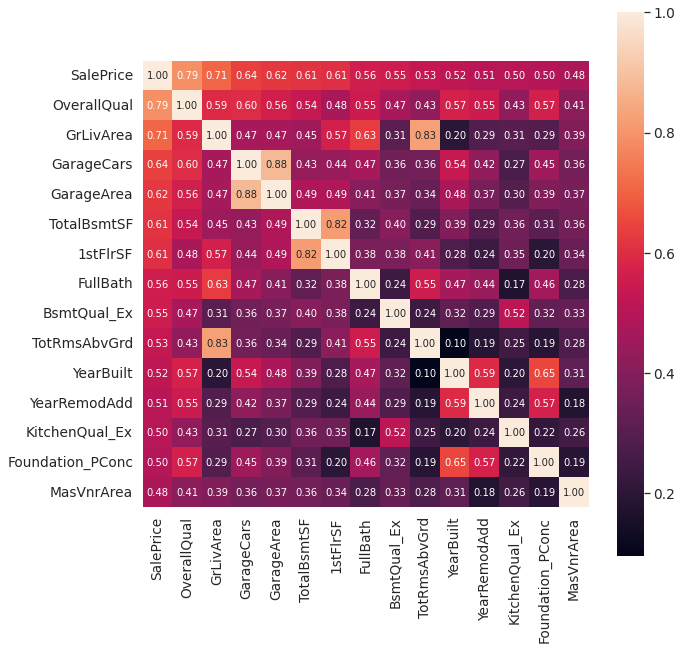

In [57]:
corrmat = train_df[included.columns].corr()
plt.figure(figsize=(10,10))
columns = corrmat.nlargest(15, 'SalePrice')['SalePrice'].index
correlation_matrix = np.corrcoef(train_df[columns].values.T)
sns.set(font_scale=1.25)
heat_map = sns.heatmap(correlation_matrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()

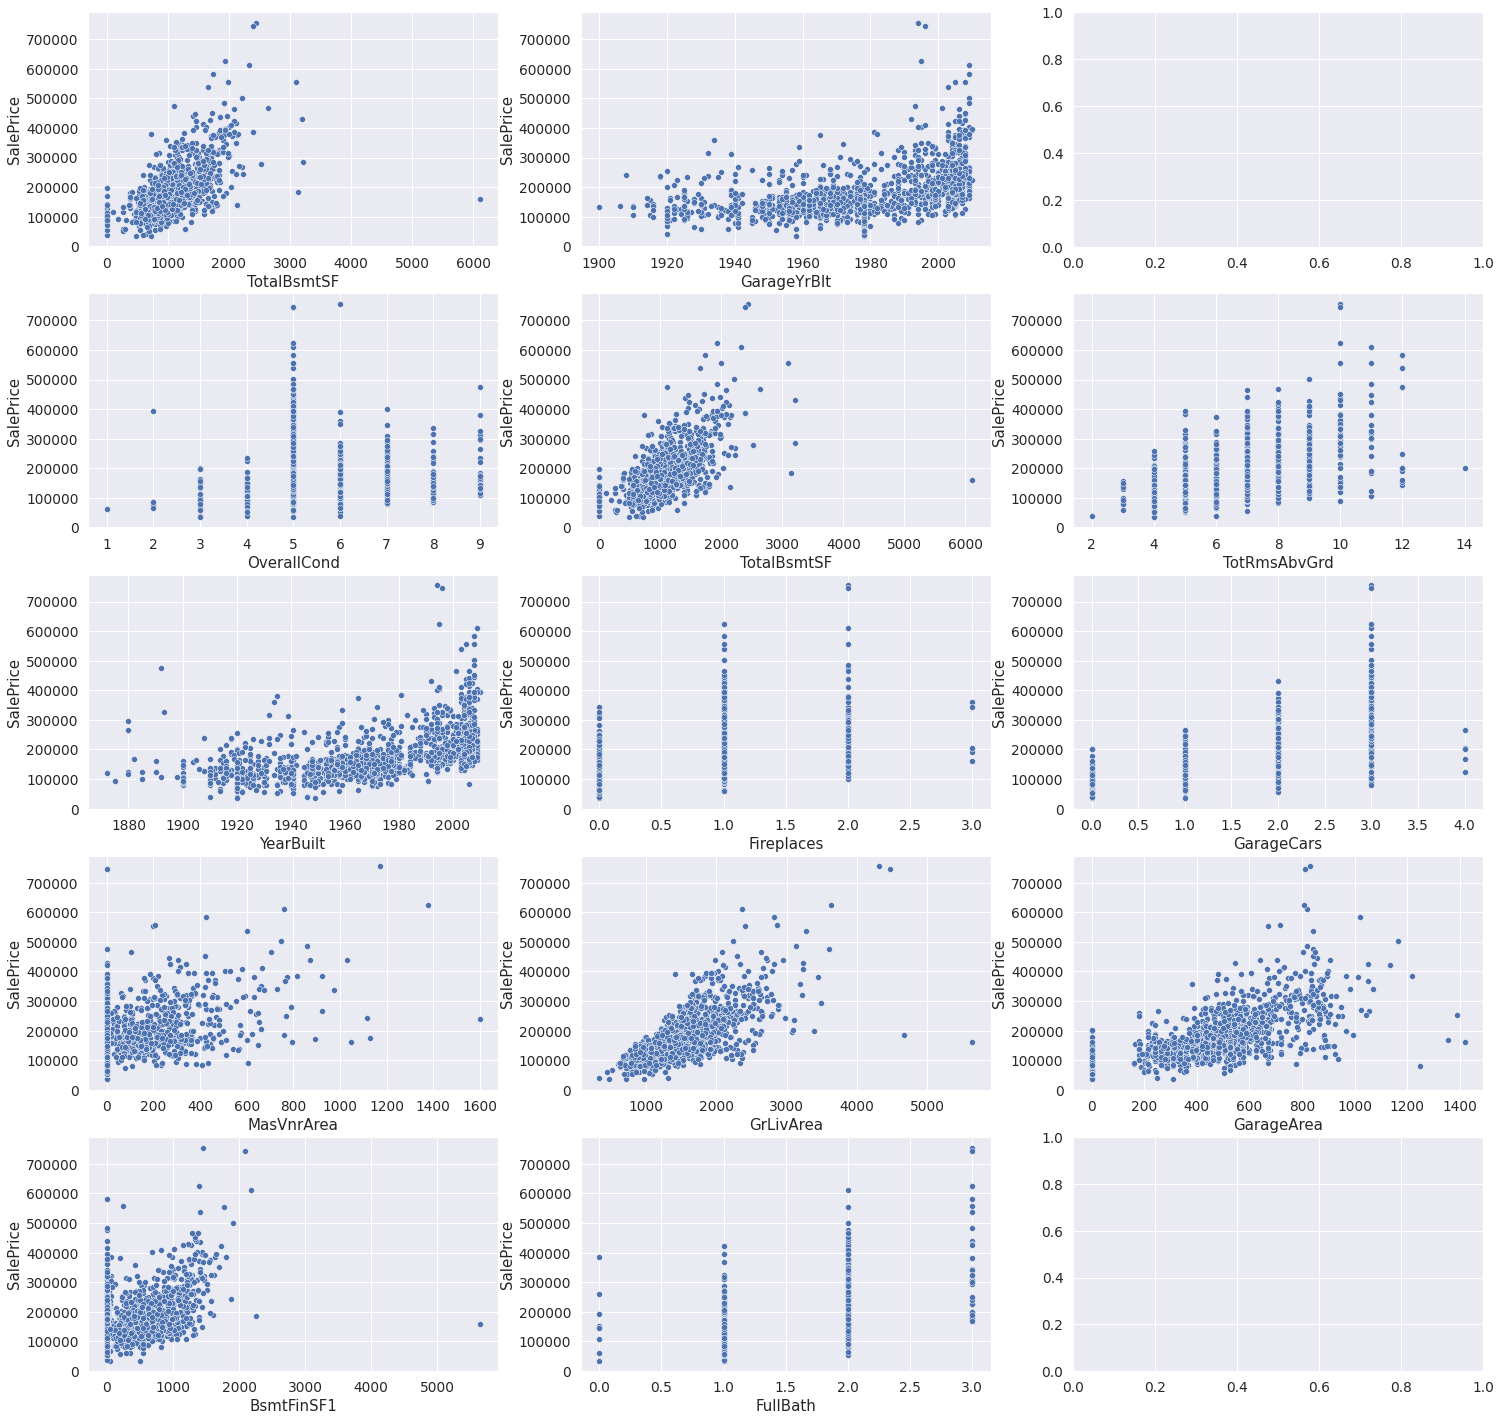

In [58]:
from pandas.plotting import scatter_matrix
plotted_features=['SalePrice','OverallCond','YearBuilt','MasVnrArea','BsmtFinSF1','TotalBsmtSF','TotalBsmtSF','Fireplaces','GrLivArea','FullBath','GarageYrBlt','TotRmsAbvGrd','GarageCars','GarageArea']
plotted_features.remove('SalePrice')
temp={}
c=0
k=5
j=0

fig5, axs = plt.subplots(k,3, figsize=(25, 25))
for i in plotted_features:
  if(c%k==0 and c!=0):
    j+=1
  c+=1  
  temp[i] = sns.scatterplot(x=train_df[i], y=train_df['SalePrice'],data=train_df, ax=axs[c%k,j])
plt.show()
plotted_features+=['SalePrice']

In [59]:
train_df = train_df[train_df.TotalBsmtSF < 4500]
train_df = train_df[train_df.GrLivArea < 4500]
train_df = train_df[train_df.GarageArea < 1200]
train_df = train_df[train_df['1stFlrSF'] < 4000]
train_df = train_df[train_df.BsmtFinSF1 < 4000]

In [60]:
from sklearn.model_selection import train_test_split
X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"]
X_Pred=test_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

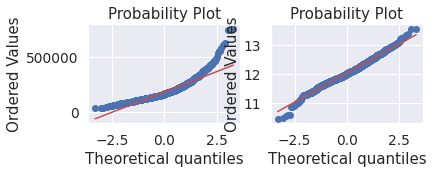

In [61]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 
fig = plt.figure()
ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
plt1 = stats.probplot(y, plot=ax)
plt2 = stats.probplot(np.log1p(y), plot=ax1)
plt.show()

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Lasso,LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
predictions=pd.DataFrame(y_train,index=y_train.index)

In [63]:
lr = make_pipeline(OneHotEncoder(handle_unknown='ignore'),LinearRegression())
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred=lr.predict(X_test)
lr.score(X_test, y_test)
predictions['LinearRegression']=y_pred_train
mean_squared_log_error(y_train,y_pred_train)

1.0634871605828209e-13

In [64]:
xgb =  make_pipeline(RobustScaler(),XGBRegressor(reg='squarederror'))
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
xgb.score(X_test, y_test)
predictions['XGBRegressor']=y_pred_train
mean_squared_log_error(y_train,y_pred_train)

[14:17:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.006741682775179227

In [65]:
enr = make_pipeline(RobustScaler(), ElasticNet(alpha=0.001, l1_ratio=.9, random_state=42))
enr.fit(X_train, y_train)
y_pred_train = enr.predict(X_train)
y_pred_test = enr.predict(X_test)
enr.score(X_test, y_test)
predictions['ElasticNet']=y_pred_train
mean_squared_log_error(y_train,y_pred_train)

0.010832376532436013

In [66]:
kr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
kr.fit(X_train, y_train)
y_pred_train = kr.predict(X_train)
y_pred_test = kr.predict(X_test)
kr.score(X_test, y_test)
predictions['KernelRidge']=y_pred_train
mean_squared_log_error(y_train,y_pred_train)

1.7761654379857184e-05

In [67]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.001, random_state=42))
lasso.fit(X_train, y_train)
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)
lasso.score(X_test, y_test)
predictions['Lasso']=y_pred_train
mean_squared_log_error(y_train,y_pred_train)

0.011038599442469014

In [68]:
gbr = GradientBoostingRegressor(n_estimators=3000, max_depth=4, min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
gbr.fit(X_train, y_train)
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)
gbr.score(X_test, y_test)
predictions['GradientBoostingRegressor']=y_pred_train
mean_squared_log_error(y_train,y_pred_train)

0.0007041528741769647

In [69]:
from mlxtend.regressor import StackingCVRegressor

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.0001)

scv = StackingCVRegressor(regressors=(lr, lasso, enr, gbr, xgb, kr),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
scv.fit(np.array(X_train), np.array(y_train))
y_pred_train = scv.predict(X_train)
y_pred_test = scv.predict(X_test)
scv.score(X_test, y_test)
predictions['StackingCVRegressor']=y_pred_train
mean_squared_log_error(y_train,y_pred_train)

[14:21:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.00225773046265007

In [70]:
predictions

,SalePrice,LinearRegression,XGBRegressor,ElasticNet,KernelRidge,Lasso,GradientBoostingRegressor,StackingCVRegressor
Id,,,,,,,,
400,241000,240999.977678,207414.937500,222016.780187,239818.937500,222302.056792,236665.528836,221407.546875
526,176000,176000.033978,178237.671875,189119.856211,177997.218750,188899.780958,176081.362053,170466.953125
1108,274725,274724.977510,265625.968750,280912.878039,274657.406250,280093.395272,274809.514466,281051.031250
396,129000,128999.989750,140379.031250,145393.460734,129162.359375,145707.099401,128897.137983,126820.437500
496,34900,34899.988551,59237.910156,53572.361371,34855.640625,53221.445152,35083.491884,48531.156250
...,...,...,...,...,...,...,...,...
259,231500,231499.991395,208307.781250,214239.817554,231503.968750,214307.503993,223425.354481,224200.062500
584,325000,324999.993143,325659.125000,324409.444811,325013.671875,324999.026000,325000.508812,305613.031250
402,164990,164989.986540,193214.984375,193371.946834,168195.031250,193342.782595,165053.316354,179981.890625


In [73]:
y_pred_test=scv.predict(X_Pred)
X_Pred['SalePrice']=y_pred_test
y_pred_test_df=X_Pred['SalePrice']
X_Pred=X_Pred.drop(columns=['SalePrice'])
y_pred_test_df.to_csv('submission.csv', index=False)
